In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langchain_core.messages import AIMessageChunk
from typing import Any, Dict, List, Callable, Optional
from dataclasses import dataclass
from langchain_core.agents import AgentAction, AgentFinish, AgentStep
from langchain.agents.output_parsers.tools import ToolAgentAction
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph
import uuid

In [3]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [4]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/RAGwithLangChain.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

data/RAGwithLangChain.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


In [5]:
search_result = pdf_retriever.invoke("RAG를 간단히 설명해주세요")

In [6]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "RAG를 간단히 설명해주세요",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

RAG(검색 보강 생성)는 사용자의 쿼리에 대한 응답을 생성하기 위해 외부 데이터 소스에서 정보를 검색하고, 이를 기반으로 언어 모델이 응답을 생성하는 시스템입니다. 이 과정은 정보 검색(Indexing), 검색(Retrieval), 생성(Generation) 단계로 구성됩니다.

**Source**
- data/RAGwithLangChain.pdf (page 4)


## State Definition

In [7]:
from langgraph.graph import MessagesState
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(MessagesState):
    # messages: Annotated[list, add_messages] # pre-built in MessagesState
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]


## Node Definition

In [8]:
from rag.utils import format_docs

def get_role_from_messages(msg):
    if isinstance(msg, HumanMessage):
        return "user"
    elif isinstance(msg, AIMessage):
        return "assistant"
    else:
        return "assistant"

def messages_to_history(messages):
    result =  "\n".join(
        [f"{get_role_from_messages(msg)}: {msg.content}" for msg in messages]
    )
    return result

# from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs

def get_role_from_messages(msg):
    if isinstance(msg, HumanMessage):
        return "user"
    elif isinstance(msg, AIMessage):
        return "assistant"
    else:
        return "assistant"


def messages_to_history(messages):
    return "\n".join(
        [f"{get_role_from_messages(msg)}: {msg.content}" for msg in messages]
    )


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

## Graph Definition

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

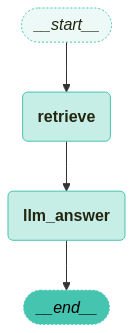

In [14]:
from utils.visualize import visualize_graph
visualize_graph(app)

In [11]:
# from dataclasses import dataclass
# from langgraph.graph.state import CompiledStateGraph
# from IPython.display import Image, display

# @dataclass
# class NodeStyles:
#     default: str = (
#         "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
#     )
#     first: str = (
#         "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
#     )
#     last: str = (
#         "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
#     )
    
# def visualize_graph(graph, xray=False):
#     """
#     CompiledStateGraph 객체를 시각화하여 표시합니다.

#     이 함수는 주어진 그래프 객체가 CompiledStateGraph 인스턴스인 경우
#     해당 그래프를 Mermaid 형식의 PNG 이미지로 변환하여 표시합니다.

#     Args:
#         graph: 시각화할 그래프 객체. CompiledStateGraph 인스턴스여야 합니다.

#     Returns:
#         None

#     Raises:
#         Exception: 그래프 시각화 과정에서 오류가 발생한 경우 예외를 출력합니다.
#     """
#     try:
#         # 그래프 시각화
#         if isinstance(graph, CompiledStateGraph):
#             display(
#                 Image(
#                     graph.get_graph(xray=xray).draw_mermaid_png(
#                         background_color="white",
#                         node_colors=NodeStyles(),
#                     )
#                 )
#             )
#     except Exception as e:
#         print(f"[ERROR] Visualize Graph Error: {e}")

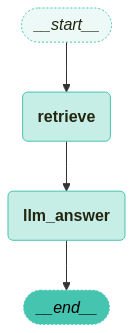

In [14]:
visualize_graph(app)